### Distance distribution from variant to tss


the idea is that the pcqtls are maybe picking up on more distant signals/regulatory elements?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

import upsetplot as up
from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
prefix = '/home/klawren/oak/pcqtls'
tissue_df = pd.read_csv(f"{prefix}/data/references/selected_tissue_ids.csv", header=0)
tissue_ids = list(tissue_df['Tissue'])

In [3]:
# load in the data from all tissues
overlap_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    overlap_dfs.append(pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t'))
overlap_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(overlap_dfs, tissue_ids)])
overlap_df.reset_index(inplace=True, drop=True)
# for debugging, try with a single tissue 

#overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_id}.v8.overlap.txt', sep='\t')

# TSS distance

In [4]:
# load in the gene information (start and strand are what I need)
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]

gene_ids = np.concatenate(overlap_df['cluster_id'].str.split('_'))
gid_gencode = full_gencode.set_index('transcript_id').loc[gene_ids]
gid_gencode = gid_gencode.drop_duplicates()

In [5]:
# add in the variant position as a column
overlap_df['lead_variant_pos'] = overlap_df['lead_variant_id'].str.split('_').str[1].astype(int)

In [6]:
# distance to whichever gene in the cluster is closest
def get_tss(row):
    cluster_gene_df = gid_gencode.loc[row['cluster_id'].split('_')]
    starts = cluster_gene_df['start'].values
    distances = abs(row['lead_variant_pos'] - starts)
    # return smallest absolute value distance
    idx = np.argmin(distances)
    # make relative to gene orientation
    if cluster_gene_df.iloc[idx]['strand'] == '-':
        return -distances[idx]
    else:
        return distances[idx]
    
# for just the egenes, get the cluster start that actually matched the gene of interest
def get_egene_distance(row):
    assert row['orig_cs_dataset'] =='control_eqtl'
    egene = row['cs_full_id'].split('_e_')[1]
    gene_df = gid_gencode.loc[egene]
    #gene_df = full_gencode[full_gencode['transcript_id']==egene].iloc[0]
    # make relative to gene orientation
    if gene_df['strand'] == '-':
        return -abs(row['lead_variant_pos']-gene_df.start)
    else:
        return abs(row['lead_variant_pos']-gene_df.start)

In [7]:
# annotate all egenes and pcqtls with the distance to the closest gene in the cluster
overlap_df['cluster_min_distance'] = overlap_df.progress_apply(get_tss, axis=1)
overlap_df.to_csv(f'{prefix}/output/overlap/all.overlap.distances.txt', sep='\t')

  0%|          | 0/87867 [00:00<?, ?it/s]

In [8]:
# annotate eqtls with the distance to their egene
e_overlap_df = overlap_df[overlap_df['orig_cs_dataset']=='control_eqtl']
e_overlap_df['egene_distance'] = e_overlap_df.progress_apply(get_egene_distance, axis=1)

  0%|          | 0/49363 [00:00<?, ?it/s]

/local/scratch/klawren/slrmtmp.42675710/ipykernel_8618/4116874800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_overlap_df['egene_distance'] = e_overlap_df.progress_apply(get_egene_distance, axis=1)


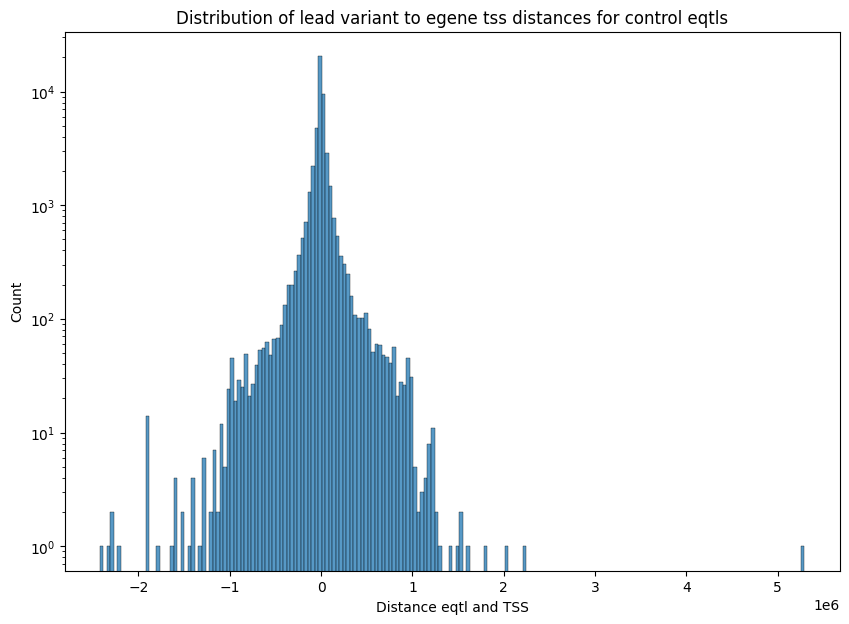

In [9]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(e_overlap_df['egene_distance'], bins=200, ax=ax)
ax.set_xlabel('Distance eqtl and TSS')
ax.set_title('Distribution of lead variant to egene tss distances for control eqtls')
ax.set_yscale('log')
plt.show()

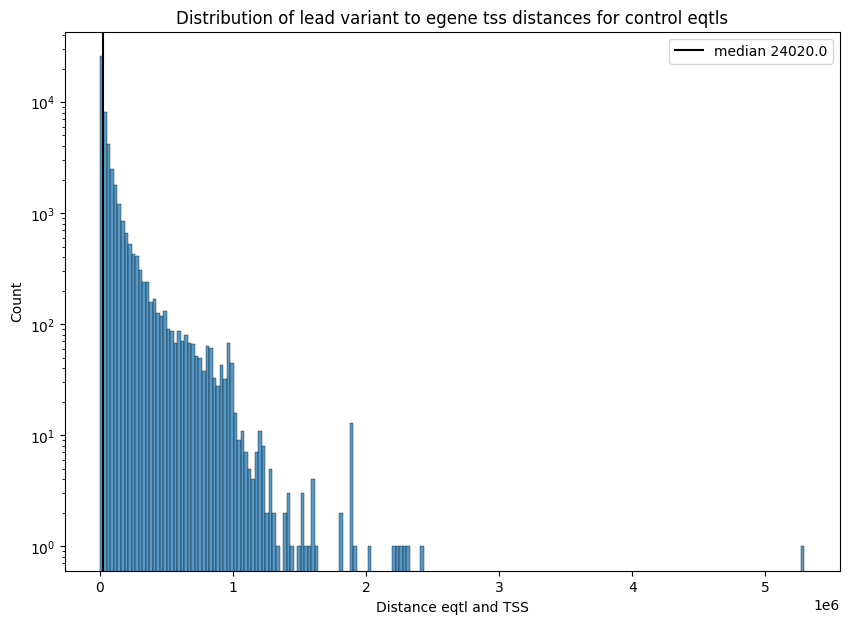

In [10]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(abs(e_overlap_df['egene_distance']), bins=200, ax=ax)
ax.set_xlabel('Distance eqtl and TSS')
ax.set_title('Distribution of lead variant to egene tss distances for control eqtls')
ax.set_yscale('log')
ax.axvline(abs(e_overlap_df['egene_distance']).median(), label='median {}'.format(abs(e_overlap_df['egene_distance']).median()), color='k')
plt.legend()
plt.show()



In [11]:
# a dataset that puts egenes in twice, once with a distance to their egene and once with a distance to the closest gene in the cluster
joined=pd.DataFrame({'distance': np.concatenate([overlap_df['cluster_min_distance'], e_overlap_df['egene_distance']]), 
              'dataset':np.concatenate([overlap_df['orig_cs_dataset'], pd.Series(['eqtl_egene_only']*len(e_overlap_df))])})
joined.loc[joined['dataset']=='control_eqtl','dataset'] ='eqtl_all_cluster_genes'
joined['abs_distance'] = joined['distance'].apply(abs)

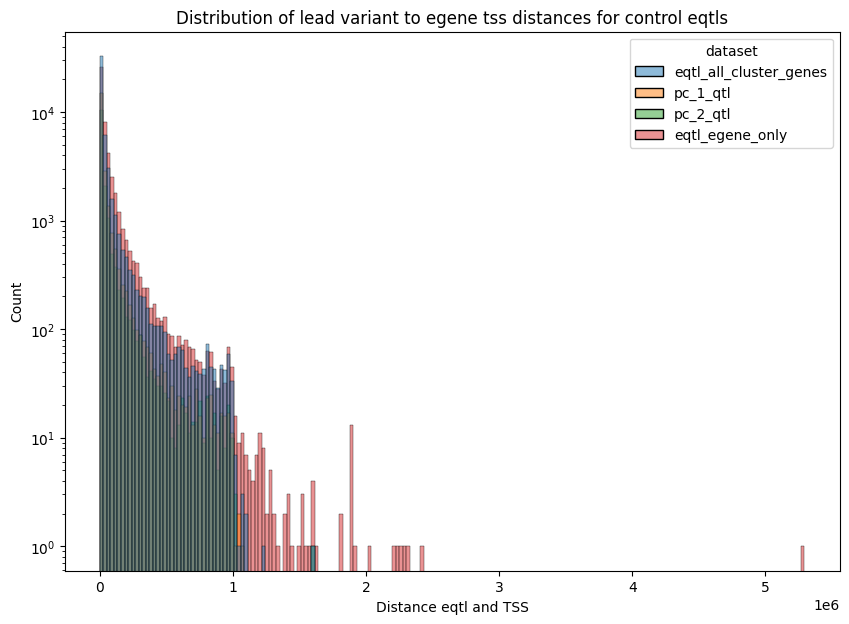

In [12]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(joined, x='abs_distance', bins=200, ax=ax, hue='dataset')
ax.set_xlabel('Distance eqtl and TSS')
ax.set_title('Distribution of lead variant to egene tss distances for control eqtls')
ax.set_yscale('log')
plt.show()

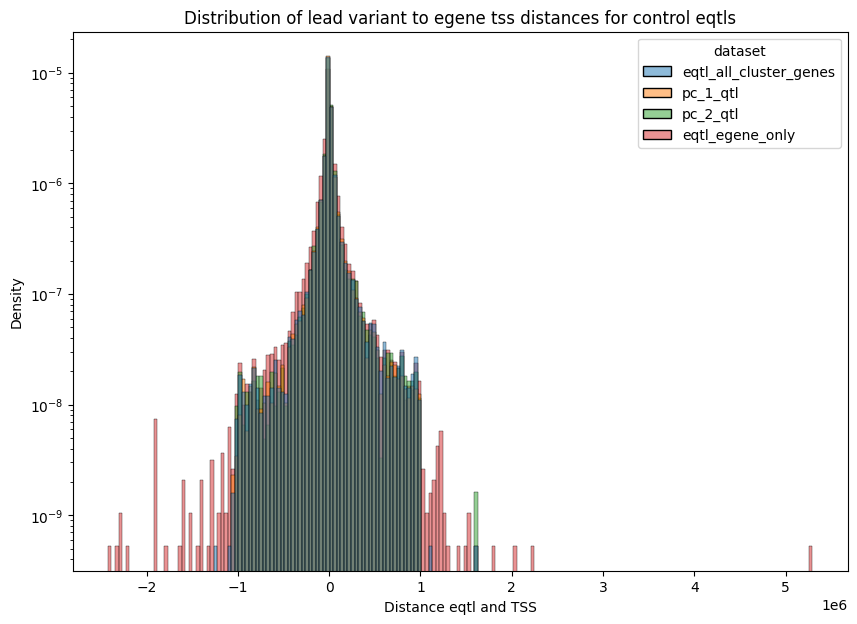

In [13]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(joined, x='distance', bins=200, ax=ax, hue='dataset', stat='density', common_norm=False)
ax.set_xlabel('Distance eqtl and TSS')
ax.set_title('Distribution of lead variant to egene tss distances for control eqtls')
ax.set_yscale('log')
plt.show()


the distance from the qtl to just the relevant egene is defiently furhter than the closest in the cluster appraoich, as would sort of be expected

Text(0.5, 1.0, 'Cumulative distribution of distances from lead variant position to closest cluster tss')

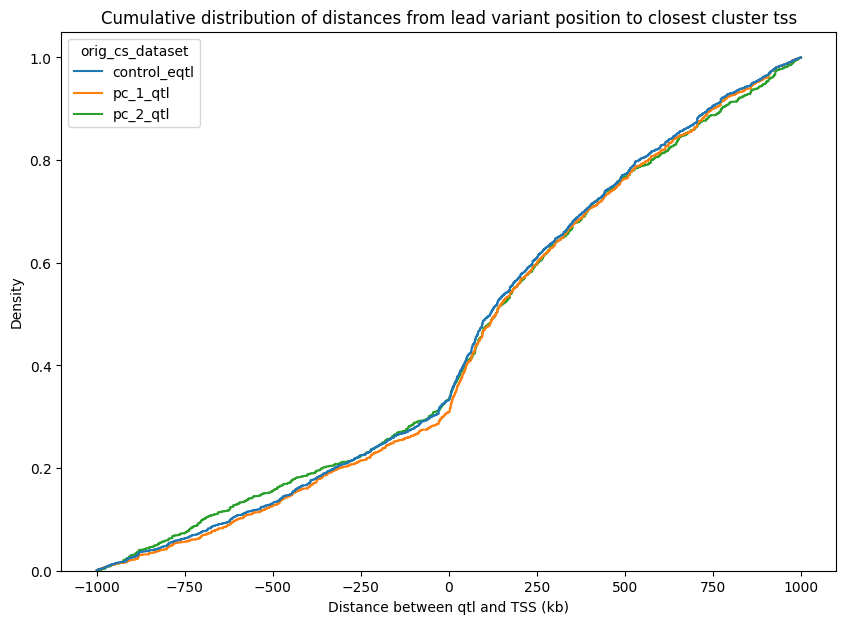

In [14]:
# plot all the closest in cluster genes together and zoom in on the middle a bit more
edge=1000
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=overlap_df, x='cluster_min_distance', bins=range(-1000, 1000, 1), hue='orig_cs_dataset', 
            stat='density', ax=ax, common_norm=False, element="step", fill=False,
            cumulative=True)
plt.xlabel('Distance between qtl and TSS (kb)')
plt.title('Cumulative distribution of distances from lead variant position to closest cluster tss')
#plt.xlim((-edge, edge))

In [15]:
# are there more before or after a certain cutoff?
overlap_df['abs_distance'] = overlap_df['cluster_min_distance'].apply(abs)

print('Median: {} bp'.format(overlap_df['abs_distance'].median()))
for dataset in overlap_df['orig_cs_dataset'].unique():
    print('\t {} median: {} bp'.format(dataset, overlap_df[overlap_df['orig_cs_dataset']==dataset]['abs_distance'].median()))

print('Mean: {:.1f} bp'.format(overlap_df['abs_distance'].mean()))
for dataset in overlap_df['orig_cs_dataset'].unique():
    print('\t {} mean: {:.1f} bp'.format(dataset, overlap_df[overlap_df['orig_cs_dataset']==dataset]['abs_distance'].mean()))

print('> 100 kb: {:.2f} % lead variants'.format(sum(overlap_df['abs_distance'] > 100000)/len(overlap_df)*100))
for dataset in overlap_df['orig_cs_dataset'].unique():
    print('\t {} > 100 kb: {:.2f} % lead variants'.format(dataset, sum(overlap_df[overlap_df['orig_cs_dataset']==dataset]['abs_distance'] > 100000)/sum(overlap_df['orig_cs_dataset']==dataset)*100))

Median: 12423.0 bp
	 control_eqtl median: 12383.0 bp
	 pc_1_qtl median: 12310.0 bp
	 pc_2_qtl median: 12907.0 bp
Mean: 51598.8 bp
	 control_eqtl mean: 52470.0 bp
	 pc_1_qtl mean: 49674.7 bp
	 pc_2_qtl mean: 51633.6 bp
> 100 kb: 12.32 % lead variants
	 control_eqtl > 100 kb: 12.43 % lead variants
	 pc_1_qtl > 100 kb: 12.16 % lead variants
	 pc_2_qtl > 100 kb: 12.23 % lead variants


### better control group

all eqtls on chr22 as a control

In [16]:
# load in the susie dfs
control_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    control_dfs.append(pd.read_csv(f'{prefix}/output/chr22_eqtl/{tissue_ids[idx]}/{tissue_ids[idx]}.v8.chr22_genes.susie.txt', sep='\t', index_col=0))
control_dfs = pd.concat([df.assign(tissue_id=n) for df, n in zip(control_dfs, tissue_ids)])
control_dfs.reset_index(inplace=True, drop=True)
# for debugging, try with a single tissue 

NameError: name 'idx' is not defined

In [ ]:
control_dfs['cs_full_id'] = control_dfs['phenotype_id'].astype(str) + '_e_cs' + control_dfs['cs_id'].astype(str) 

def get_lead_var(susie_df):
    return susie_df.loc[susie_df.groupby('cs_full_id')['pip'].idxmax(),['cs_full_id','variant_id']].set_index('cs_full_id')


control_df = pd.DataFrame(pd.Series(control_dfs.groupby(['cs_full_id'])['variant_id'].apply(list), name='variant_list'))
control_df['lead_variant_id'] = get_lead_var(control_dfs)
control_df = control_df.reset_index()
control_df['lead_variant_pos'] = control_df['lead_variant_id'].str.split('_').str[1].astype(int)
control_df

,cs_full_id,variant_list,lead_variant_id,lead_variant_pos
0,ENSG00000015475.18_e_cs1,"[chr22_17643254_T_C_b38, chr22_17648460_C_T_b3...",chr22_17733496_G_C_b38,17733496
1,ENSG00000025708.13_e_cs1,"[chr22_50532618_T_C_b38, chr22_50532618_T_C_b3...",chr22_50532618_T_C_b38,50532618
2,ENSG00000069998.12_e_cs1,"[chr22_17168078_T_C_b38, chr22_17168078_T_C_b3...",chr22_17168078_T_C_b38,17168078
3,ENSG00000069998.12_e_cs2,"[chr22_17134961_G_A_b38, chr22_17135261_G_A_b3...",chr22_17135355_A_G_b38,17135355
4,ENSG00000070371.15_e_cs1,"[chr22_19182668_C_T_b38, chr22_19239244_T_C_b3...",chr22_19292035_C_T_b38,19292035
...,...,...,...,...
375,ENSG00000283633.1_e_cs1,"[chr22_16601823_C_T_b38, chr22_16607971_G_C_b3...",chr22_16601823_C_T_b38,16601823
376,ENSG00000283633.1_e_cs2,"[chr22_16597059_G_A_b38, chr22_16602700_C_G_b3...",chr22_16602700_C_G_b38,16602700
377,ENSG00000284070.1_e_cs1,"[chr22_24263662_ACCGG_A_b38, chr22_24282513_A_...",chr22_24263662_ACCGG_A_b38,24263662
378,ENSG00000284070.1_e_cs2,"[chr22_24662044_AT_A_b38, chr22_24662059_G_A_b...",chr22_24662044_AT_A_b38,24662044


In [ ]:
def get_control_tss(row):
    egene = row['cs_full_id'].split('_e_')[0]
    gene_df = full_gencode.set_index('transcript_id').loc[egene]
    #gene_df = full_gencode[full_gencode['transcript_id']==egene].iloc[0]
    # make relative to gene orientation
    if gene_df['strand'] == '-':
        return -abs(row['lead_variant_pos']-gene_df.start)
    else:
        return abs(row['lead_variant_pos']-gene_df.start)

In [ ]:
control_df['tss_distance'] = control_df.progress_apply(get_control_tss, axis=1)
control_df['abs_distance'] = control_df['tss_distance'].apply(abs)

  0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
joined=pd.DataFrame({'distance': np.concatenate([overlap_df['cluster_min_distance'], e_overlap_df['egene_distance']]), 
              'dataset':np.concatenate([overlap_df['orig_cs_dataset'], pd.Series(['eqtl_egene_only']*len(e_overlap_df))])})
joined.loc[joined['dataset']=='control_eqtl','dataset'] ='eqtl_all_cluster_genes'

In [ ]:
control_joined = pd.DataFrame({'distance':control_df['tss_distance'], 'dataset':['all_egene_control']*len(control_df), 'abs_distance':control_df['abs_distance']})

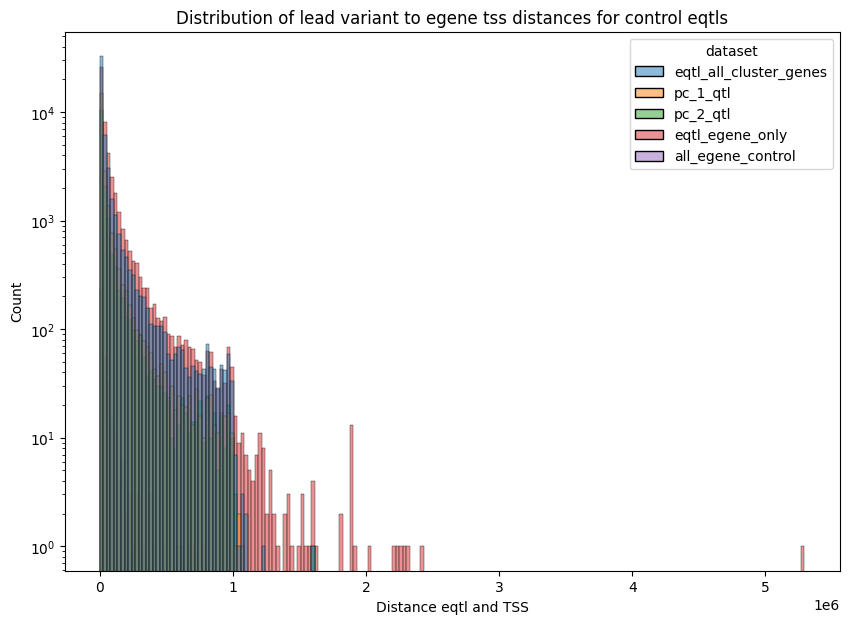

In [ ]:
# plot for just the egene distances
fig, ax = plt.subplots(figsize=(10,7))

sns.histplot(pd.concat([joined, control_joined]), x='abs_distance', bins=200, ax=ax, hue='dataset')
ax.set_xlabel('Distance eqtl and TSS')
ax.set_title('Distribution of lead variant to egene tss distances for control eqtls')
ax.set_yscale('log')
plt.show()